----
<div align="center">
  <h2><strong><em>CSC417: Machine Intelligence Project</em></strong></h2>
</div>

----

<div style="border: 1px solid #ddd; border-radius: 8px; padding: 16px; width: 350px; font-family: sans-serif; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
  <p style="margin: 0 0 8px 0;">
    <strong>Name:</strong> 
    <em style="color: #c9302c; font-weight: bold;">Ammar Tarek Khattab</em>
  </p>
  <p style="margin: 0;">
    <strong>ID:</strong> 
    <em style="color: #c9302c; font-weight: bold;">202002123</em>
  </p>
</div>

<font size="4" color="#6495ED">***1. Import Libraries:***</font>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
import warnings
import json
warnings.filterwarnings('ignore')

In [8]:
# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

<font size="4" color="#6495ED">***2. Load Dataset:***</font>

In [9]:
# Updated path to processed dataset
data_path = Path('../data/processed/pirvision_combined.csv')

if data_path.exists():
    df = pd.read_csv(data_path)
    print(f"✅ Dataset loaded successfully from: {data_path}")
    print(f"Shape: {df.shape}")
else:
    # Try alternative paths
    alt_path1 = Path('../data/raw/pirvision_office_dataset1.csv')
    alt_path2 = Path('../data/raw/pirvision_office_dataset2.csv')
    
    if alt_path1.exists() and alt_path2.exists():
        print("Loading from raw files...")
        df1 = pd.read_csv(alt_path1)
        df2 = pd.read_csv(alt_path2)
        df = pd.concat([df1, df2], axis=0, ignore_index=True)
        df = df.drop_duplicates()
        print(f"✅ Dataset loaded from raw files and combined!")
        print(f"Shape: {df.shape}")
    else:
        print("❌ Dataset not found. Please run prepare_dataset.py first")
        print(f"Looked for: {data_path}")

✅ Dataset loaded successfully from: ..\data\processed\pirvision_combined.csv
Shape: (7651, 59)


<font size="4" color="#6495ED">***3. Load Metadata:***</font>

In [10]:
metadata_path = Path('../data/processed/dataset_metadata_fixed.json')
if not metadata_path.exists():
    metadata_path = Path('../data/processed/dataset_metadata.json')

if metadata_path.exists():
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    print(f"✅ Metadata loaded from: {metadata_path}")
else:
    print("⚠️ Metadata file not found, will analyze from scratch")
    metadata = None

✅ Metadata loaded from: ..\data\processed\dataset_metadata_fixed.json


<font size="4" color="#6495ED">***4. Extract Basic Dataset Information:***</font>

In [11]:
def get_dataset_info(df):
    """Get comprehensive dataset information"""
    
    print("="*60)
    print("DATASET INFORMATION")
    print("="*60)
    
    # Basic info
    print(f"\n📊 Basic Statistics:")
    print(f"  • Total samples: {len(df):,}")
    print(f"  • Total features: {len(df.columns)}")
    print(f"  • Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    
    # Identify feature types correctly
    pir_features = [col for col in df.columns if 'PIR' in col]
    temp_features = ['Temperature_F'] if 'Temperature_F' in df.columns else []
    time_features = ['Date', 'Time'] if all(col in df.columns for col in ['Date', 'Time']) else []
    
    # IMPORTANT: Correct target identification
    target_col = 'Label' if 'Label' in df.columns else None
    
    print(f"\n🔍 Feature Categories:")
    print(f"  • PIR sensors: {len(pir_features)} features")
    if pir_features:
        print(f"    - Sensors: {pir_features[0]} ... {pir_features[-1]}")
    print(f"  • Temperature: {len(temp_features)} features")
    print(f"  • Temporal: {len(time_features)} features")
    
    # Target variable - CORRECTED
    if target_col:
        print(f"\n🎯 Target Variable: '{target_col}'")
        print(f"  • Unique values: {sorted(df[target_col].unique())}")
        print(f"  • Class distribution:")
        for val, count in df[target_col].value_counts().sort_index().items():
            print(f"    - Class {val}: {count:,} ({count/len(df)*100:.2f}%)")
    else:
        print(f"\n⚠️ Target variable 'Label' not found in dataset")
    
    # Missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n⚠️ Missing Values:")
        for col, count in missing[missing > 0].items():
            print(f"  • {col}: {count} ({count/len(df)*100:.2f}%)")
    else:
        print(f"\n✅ No missing values found!")
    
    return {
        'pir_features': pir_features,
        'temp_features': temp_features,
        'time_features': time_features,
        'target_col': target_col
    }

feature_info = get_dataset_info(df)

DATASET INFORMATION

📊 Basic Statistics:
  • Total samples: 7,651
  • Total features: 59
  • Memory usage: 3.44 MB

🔍 Feature Categories:
  • PIR sensors: 55 features
    - Sensors: PIR_1 ... PIR_55
  • Temperature: 1 features
  • Temporal: 2 features

🎯 Target Variable: 'Label'
  • Unique values: [0, 1, 3]
  • Class distribution:
    - Class 0: 6,247 (81.65%)
    - Class 1: 833 (10.89%)
    - Class 3: 571 (7.46%)

✅ No missing values found!


<font size="4" color="#6495ED">***5. Data Types and Ranges:***</font>

In [12]:
print("\n📋 Data Types and Ranges:")
print("-"*60)

# Show non-PIR columns first
non_pir_cols = [col for col in df.columns if 'PIR' not in col]
print("Non-PIR columns:")
for col in non_pir_cols:
    if df[col].dtype in ['float64', 'int64', 'int32', 'float32']:
        # Numeric columns - show range
        print(f"  {col:20} | {str(df[col].dtype):10} | Range: [{df[col].min():.2f}, {df[col].max():.2f}]")
    else:
        # Non-numeric columns (object/string) - show unique values count
        print(f"  {col:20} | {str(df[col].dtype):10} | Unique values: {df[col].nunique()}")
        # Show sample values for string columns
        if df[col].dtype == 'object':
            sample_values = df[col].unique()[:3]  # First 3 unique values
            sample_str = ', '.join([str(v) for v in sample_values])
            if len(df[col].unique()) > 3:
                sample_str += '...'
            print(f"    Sample values: {sample_str}")

# Show PIR columns summary
if feature_info['pir_features']:
    print(f"\nPIR Sensors ({len(feature_info['pir_features'])} total):")
    # Show first 5 and last 5
    for col in feature_info['pir_features'][:5]:
        print(f"  {col:20} | Range: [{df[col].min():5.0f}, {df[col].max():5.0f}] | Mean: {df[col].mean():8.1f}")
    if len(feature_info['pir_features']) > 10:
        print("  ...")
        for col in feature_info['pir_features'][-5:]:
            print(f"  {col:20} | Range: [{df[col].min():5.0f}, {df[col].max():5.0f}] | Mean: {df[col].mean():8.1f}")


📋 Data Types and Ranges:
------------------------------------------------------------
Non-PIR columns:
  Date                 | object     | Unique values: 3
    Sample values: 2024-08-08, 2024-09-08, 2024-10-08
  Time                 | object     | Unique values: 6424
    Sample values: 19:19:56, 19:20:12, 19:20:28...
  Label                | int64      | Range: [0.00, 3.00]
  Temperature_F        | int64      | Range: [0.00, 89.00]

PIR Sensors (55 total):
  PIR_1                | Range: [ 2613, 111602625] | Mean: 250125.6
  PIR_2                | Range: [ 2615, 16383] | Mean:  11013.9
  PIR_3                | Range: [ 2614, 16383] | Mean:  11517.8
  PIR_4                | Range: [ 2611, 16383] | Mean:  11578.5
  PIR_5                | Range: [ 2612, 16383] | Mean:  11269.1
  ...
  PIR_51               | Range: [ 2609, 16383] | Mean:  11103.1
  PIR_52               | Range: [ 2605, 16383] | Mean:  10919.3
  PIR_53               | Range: [ 2604, 16383] | Mean:  10743.0
  PIR_54      

<font size="4" color="#6495ED">***6. Statistical Summary:***</font>

In [13]:
print("\n📊 Statistical Summary of Key Features:")
print("="*60)

# Summary for non-PIR features
if non_pir_cols:
    numeric_non_pir = [col for col in non_pir_cols if df[col].dtype in ['float64', 'int64']]
    if numeric_non_pir:
        print("\nNon-PIR Features Statistics:")
        print(df[numeric_non_pir].describe())

# Summary for PIR features (aggregate)
if feature_info['pir_features']:
    pir_df = df[feature_info['pir_features']]
    print("\nPIR Sensors Aggregate Statistics:")
    pir_summary = pd.DataFrame({
        'Mean across sensors': pir_df.mean(axis=1).describe(),
        'Std across sensors': pir_df.std(axis=1).describe(),
        'Max across sensors': pir_df.max(axis=1).describe(),
        'Min across sensors': pir_df.min(axis=1).describe()
    }).T
    print(pir_summary)


📊 Statistical Summary of Key Features:

Non-PIR Features Statistics:
             Label  Temperature_F
count  7651.000000    7651.000000
mean      0.332767      80.383871
std       0.818477      22.861417
min       0.000000       0.000000
25%       0.000000      86.000000
50%       0.000000      86.000000
75%       0.000000      88.000000
max       3.000000      89.000000

PIR Sensors Aggregate Statistics:
                      count           mean           std           min  \
Mean across sensors  7651.0   14691.619579  7.804891e+04   8679.345455   
Std across sensors   7651.0   33110.713164  5.788253e+05     70.804834   
Max across sensors   7651.0  251446.189387  4.292924e+06  10380.000000   
Min across sensors   7651.0    8564.192916  7.686347e+02   2602.000000   

                              25%           50%           75%           max  
Mean across sensors  10322.827273  10337.981818  10354.200000  2.039466e+06  
Std across sensors     606.677625    753.898279    954.957807 

<font size="4" color="#6495ED">***7. Target Variable Distribution Visualization:***</font>

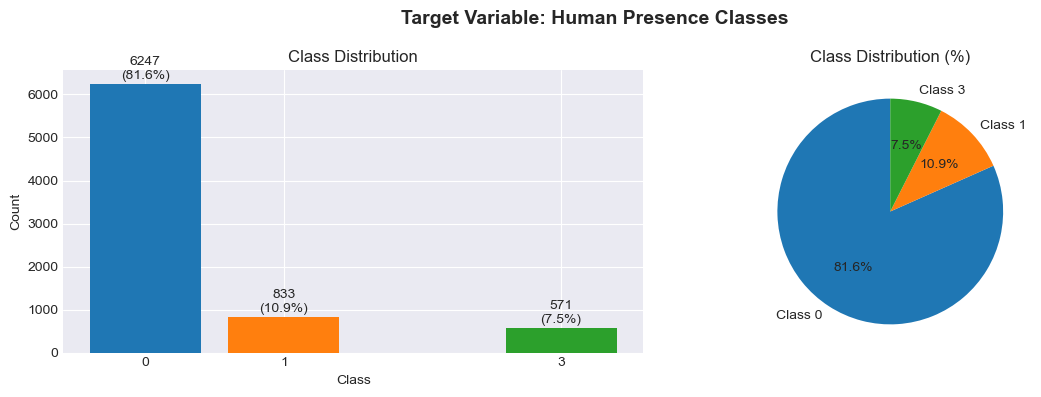


📊 Class Interpretation (PIRvision_FoG Dataset):
  • Class 0: Vacancy (no human presence)
  • Class 1: Stationary human presence
  • Class 3: Human activity/motion


In [14]:
if feature_info['target_col']:
    target_col = feature_info['target_col']
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Bar plot
    class_counts = df[target_col].value_counts().sort_index()
    axes[0].bar(class_counts.index, class_counts.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Class Distribution')
    axes[0].set_xticks(class_counts.index)
    
    # Add value labels on bars
    for i, (cls, count) in enumerate(class_counts.items()):
        axes[0].text(cls, count + 50, f'{count}\n({count/len(df)*100:.1f}%)', 
                    ha='center', va='bottom')
    
    # Pie chart
    axes[1].pie(class_counts.values, labels=[f'Class {i}' for i in class_counts.index],
                autopct='%1.1f%%', startangle=90, colors=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[1].set_title('Class Distribution (%)')
    
    plt.suptitle('Target Variable: Human Presence Classes', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Interpretation
    print("\n📊 Class Interpretation (PIRvision_FoG Dataset):")
    print("  • Class 0: Vacancy (no human presence)")
    print("  • Class 1: Stationary human presence")
    if 3 in df[target_col].unique():
        print("  • Class 3: Human activity/motion")

<font size="4" color="#6495ED">***8. PIR Sensor Overview:***</font>


🔍 PIR Sensor Analysis


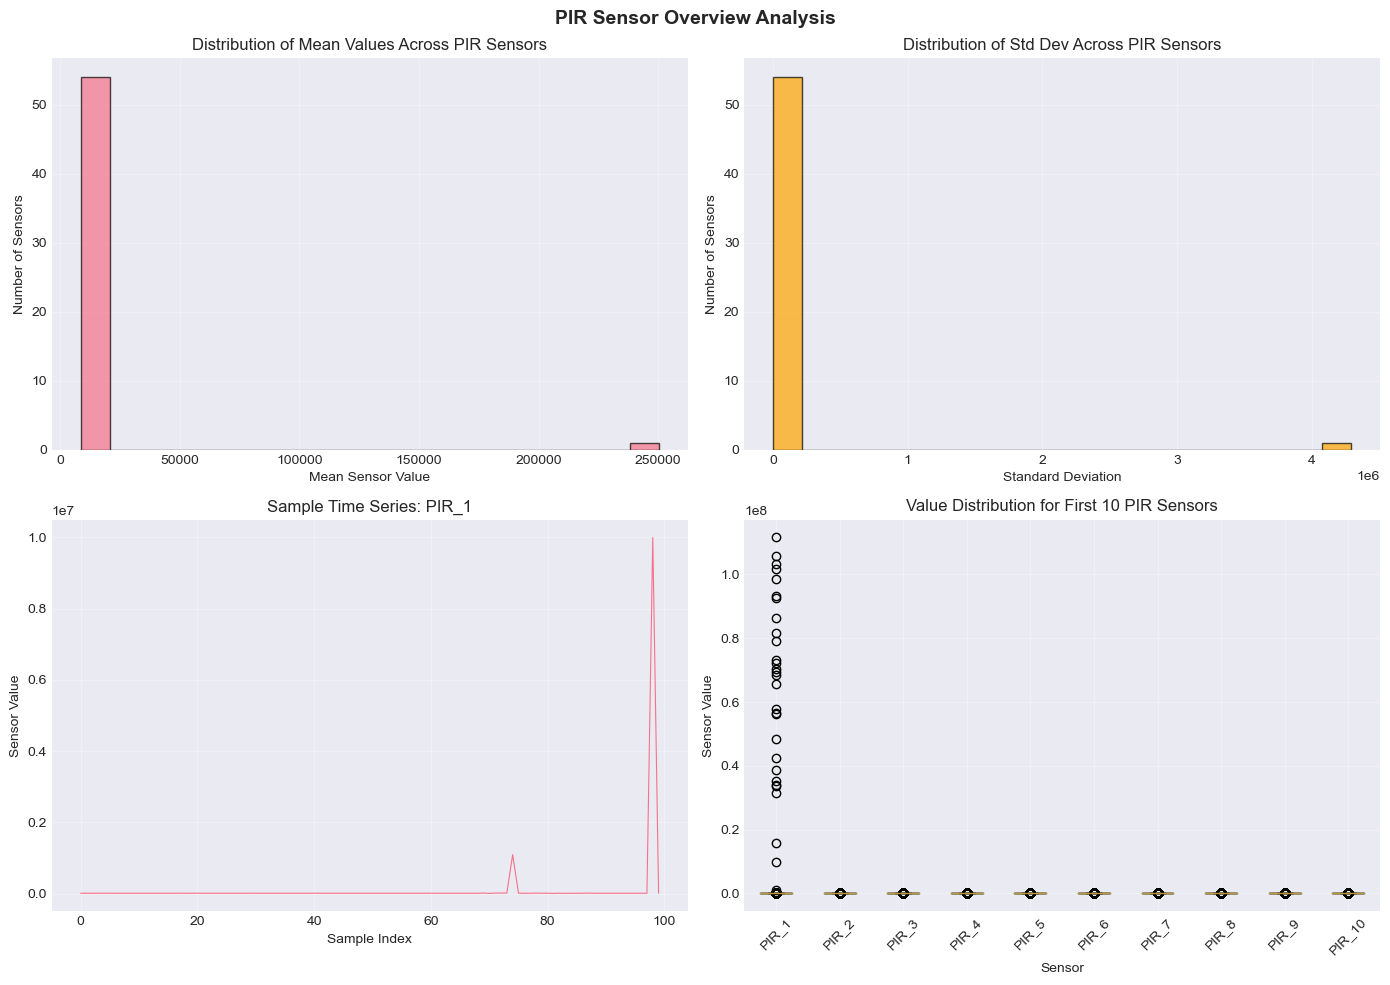

PIR Sensor Statistics:
  • Number of sensors: 55
  • Overall mean: 14691.62
  • Overall std: 579716.56
  • Overall min: 2602
  • Overall max: 111602625


In [15]:
if feature_info['pir_features']:
    print("\n🔍 PIR Sensor Analysis")
    print("="*60)
    
    # Calculate overall statistics
    pir_data = df[feature_info['pir_features']]
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Distribution of mean values across all PIR sensors
    mean_values = pir_data.mean()
    axes[0, 0].hist(mean_values, bins=20, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Distribution of Mean Values Across PIR Sensors')
    axes[0, 0].set_xlabel('Mean Sensor Value')
    axes[0, 0].set_ylabel('Number of Sensors')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Distribution of std values across all PIR sensors
    std_values = pir_data.std()
    axes[0, 1].hist(std_values, bins=20, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].set_title('Distribution of Std Dev Across PIR Sensors')
    axes[0, 1].set_xlabel('Standard Deviation')
    axes[0, 1].set_ylabel('Number of Sensors')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Sample time series for first PIR sensor
    if len(df) > 100:
        sample_data = df[feature_info['pir_features'][0]].iloc[:100]
    else:
        sample_data = df[feature_info['pir_features'][0]]
    axes[1, 0].plot(sample_data.values, linewidth=0.8)
    axes[1, 0].set_title(f'Sample Time Series: {feature_info["pir_features"][0]}')
    axes[1, 0].set_xlabel('Sample Index')
    axes[1, 0].set_ylabel('Sensor Value')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Boxplot of first 10 PIR sensors
    sensors_to_plot = min(10, len(feature_info['pir_features']))
    axes[1, 1].boxplot([df[col].values for col in feature_info['pir_features'][:sensors_to_plot]],
                       labels=[f'PIR_{i+1}' for i in range(sensors_to_plot)])
    axes[1, 1].set_title(f'Value Distribution for First {sensors_to_plot} PIR Sensors')
    axes[1, 1].set_xlabel('Sensor')
    axes[1, 1].set_ylabel('Sensor Value')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.suptitle('PIR Sensor Overview Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"PIR Sensor Statistics:")
    print(f"  • Number of sensors: {len(feature_info['pir_features'])}")
    print(f"  • Overall mean: {pir_data.values.mean():.2f}")
    print(f"  • Overall std: {pir_data.values.std():.2f}")
    print(f"  • Overall min: {pir_data.values.min():.0f}")
    print(f"  • Overall max: {pir_data.values.max():.0f}")

<font size="4" color="#6495ED">***9. Temporal Analysis:***</font>


⏰ Temporal Analysis
Data Collection Period:
  • Start: 2024-08-08 19:19:56
  • End: 2024-10-08 04:35:21
  • Duration: 60 days 09:15:25
  • Sampling interval: ~16.0 seconds


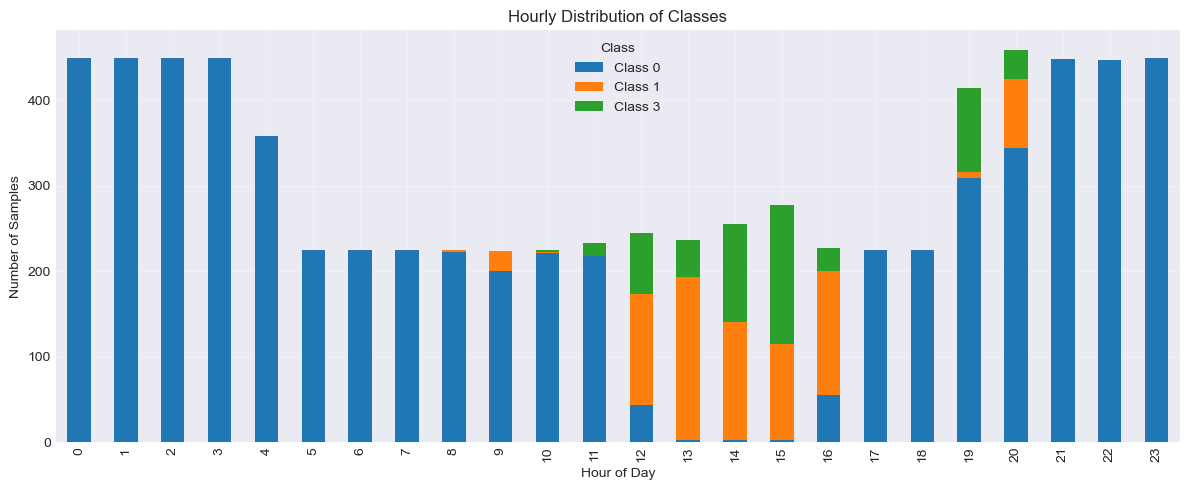

In [16]:
if all(col in df.columns for col in ['Date', 'Time']):
    print("\n⏰ Temporal Analysis")
    print("="*60)
    
    # Create datetime column
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    
    # Extract temporal features
    df['Hour'] = df['DateTime'].dt.hour
    df['Minute'] = df['DateTime'].dt.minute
    
    print(f"Data Collection Period:")
    print(f"  • Start: {df['DateTime'].min()}")
    print(f"  • End: {df['DateTime'].max()}")
    print(f"  • Duration: {df['DateTime'].max() - df['DateTime'].min()}")
    print(f"  • Sampling interval: ~{(df['DateTime'].iloc[1] - df['DateTime'].iloc[0]).total_seconds()} seconds")
    
    # Plot temporal distribution
    if feature_info['target_col']:
        fig, ax = plt.subplots(figsize=(12, 5))
        
        hourly_dist = df.groupby(['Hour', feature_info['target_col']]).size().unstack(fill_value=0)
        hourly_dist.plot(kind='bar', stacked=True, ax=ax, 
                         color=['#1f77b4', '#ff7f0e', '#2ca02c'])
        ax.set_title('Hourly Distribution of Classes')
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Number of Samples')
        ax.legend(title='Class', labels=[f'Class {i}' for i in hourly_dist.columns])
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


<font size="4" color="#6495ED">***10. Temperature Analysis:***</font>


🌡️ Temperature Analysis
Temperature Statistics:
  • Range: 0°F - 89°F
  • Mean: 80.4°F
  • Std: 22.9°F
  • Median: 86.0°F


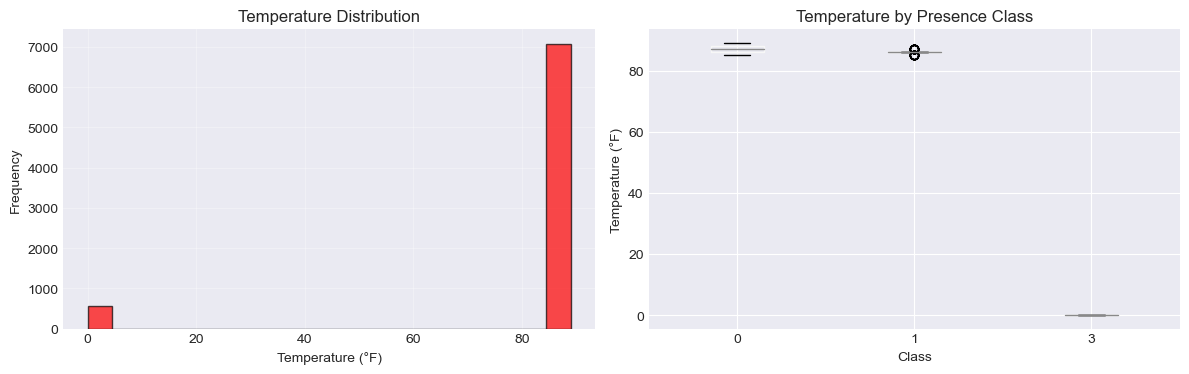

In [17]:
if 'Temperature_F' in df.columns:
    print("\n🌡️ Temperature Analysis")
    print("="*60)
    
    print(f"Temperature Statistics:")
    print(f"  • Range: {df['Temperature_F'].min()}°F - {df['Temperature_F'].max()}°F")
    print(f"  • Mean: {df['Temperature_F'].mean():.1f}°F")
    print(f"  • Std: {df['Temperature_F'].std():.1f}°F")
    print(f"  • Median: {df['Temperature_F'].median():.1f}°F")
    
    # Visualize temperature
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Histogram
    axes[0].hist(df['Temperature_F'], bins=20, edgecolor='black', alpha=0.7, color='red')
    axes[0].set_title('Temperature Distribution')
    axes[0].set_xlabel('Temperature (°F)')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, alpha=0.3)
    
    # Temperature by class (if target exists)
    if feature_info['target_col']:
        df.boxplot(column='Temperature_F', by=feature_info['target_col'], ax=axes[1])
        axes[1].set_title('Temperature by Presence Class')
        axes[1].set_xlabel('Class')
        axes[1].set_ylabel('Temperature (°F)')
        plt.suptitle('')  # Remove the automatic title
    
    plt.tight_layout()
    plt.show()

<font size="4" color="#6495ED">***11. Save Initial Analysis Results:***</font>

In [18]:
analysis_summary = {
    'dataset_path': str(data_path),
    'shape': df.shape,
    'num_pir_sensors': len(feature_info['pir_features']),
    'target_column': feature_info['target_col'],
    'features': {
        'pir': len(feature_info['pir_features']),
        'temporal': len(feature_info['time_features']),
        'environmental': len(feature_info['temp_features'])
    }
}

if feature_info['target_col']:
    analysis_summary['class_distribution'] = df[feature_info['target_col']].value_counts().to_dict()

# Save summary
summary_path = Path('../data/processed/initial_analysis_summary.json')
with open(summary_path, 'w') as f:
    json.dump(analysis_summary, f, indent=4)

print(f"\n✅ Initial analysis complete!")
print(f"📁 Summary saved to: {summary_path}")
print("\n🎯 Next Steps:")
print("  1. Run fix_dataset.py to correct metadata")
print("  2. Run comprehensive EDA notebook (02_comprehensive_eda.ipynb)")
print("  3. Run feature engineering script")
print("  4. Proceed to model development")


✅ Initial analysis complete!
📁 Summary saved to: ..\data\processed\initial_analysis_summary.json

🎯 Next Steps:
  1. Run fix_dataset.py to correct metadata
  2. Run comprehensive EDA notebook (02_comprehensive_eda.ipynb)
  3. Run feature engineering script
  4. Proceed to model development
